In [2]:
import pickle
import os
import re
import json
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.stats import kstest, shapiro, normaltest, zscore
import statsmodels.api as sm

from functools import reduce

In [3]:
# Enable automatic reloading of modules before executing code
%load_ext autoreload
%autoreload 2


import plotting as pl
from models import model as md
import utils as ut

In [4]:
def max_epoch(l_files):
    the_number = []
    for f in l_files:
        # extract number and store
        mtch = re.search(r"epoch(\d{4})\.txt$", f)
        try:
            the_number.append(mtch.groups()[0])
        except:
            the_number.append("0")
    the_number_int = [int(n) for n in the_number]
    max_value = max(the_number_int)
    indices = [index for index, value in enumerate(the_number_int) if value == max_value]
    file_to_extract = l_files[indices[0]]
    file_to_extract = file_to_extract.replace(".txt", ".tar")
    file_to_extract = file_to_extract.replace("sparse_embed", "model")
    return file_to_extract

In [5]:
def extract_results_id(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype = "weightsonly_only_weights", l_temperature = []
):
    all_dirs = []
    l_all_results = []
    l_all_models = []
    l_sparsity = []
    l_subject = []
    for n in l_n:
        for splithalf in l_splithalf:
            for la in lmbda:
                for la_h in lmbda_hierarchical:
                    for sp in l_sparse:
                        for st in l_subjecttype:
                            if l_temperature == []:
                                results_dir_ID = os.path.join(
                                    "./results", modelversion, f"modeltype_{modeltype}", f"splithalf_{splithalf}",
                                    f'{n}d', str(la), str(la_h), sp, st, f'seed{rnd_seed}'
                                    )
                                all_dirs.append(results_dir_ID)
                                l_sparsity.append(sp)
                                l_subject.append(st)
                            else:
                                for temp in l_temperature:
                                    results_dir_ID = os.path.join(
                                        "./results", modelversion, f"modeltype_{modeltype}", f"splithalf_{splithalf}", f"temperature_{temp}",
                                        f'{n}d', str(la), str(la_h), sp, st, f'seed{rnd_seed}'
                                        )
                                    all_dirs.append(results_dir_ID)
                                    l_sparsity.append(sp)
                                    l_subject.append(st)
    for i, d in enumerate(all_dirs):
        file_path = os.path.join(d, 'results.json')
        if os.path.isfile(file_path):
            with open(file_path, "r") as f:
                l_results = json.load(f)
                l_all_results.append(l_results)
        else:
            print(file_path + ": not found")
        l_files = os.listdir(results_dir_ID)
        latest_epoch = max_epoch(l_files)
        p = os.path.join(d, "model", latest_epoch)
        if os.path.isfile(p):
            m = torch.load(p, weights_only=True, map_location=torch.device("cpu"))
            m["sparsity"] = l_sparsity[i]
            m["subject_type"] = l_subject[i]
            l_all_models.append(m)
        else:
            print(f'{p} does not exist')
    return l_all_models

In [75]:
# by-participant decision models
lmbda = [0.0005]
lmbda_hierarchical = [0.01]
rnd_seed = '998877'
modelversion = "avg-ID-jointly-embeddings-decision"
l_n = [5, 10, 15, 20, 30, 40, 50]
l_sparse = ["items_and_random_ids"]#["ID", "both"] #"both", 
l_subjecttype = ["subjects_actual", "subjects_shuffled"]
l_splithalf = ["no"]
l_all_models_id_1 = extract_results_id(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse, 
    l_subjecttype, l_splithalf, modeltype="random_weights_free_scaling",
)

In [490]:
# by-participant embedding models (no by-participant decision models)
modelversion = "avg-ID-jointly-embeddings"
l_n = [15, 20, 30, 40]
l_temperature = [10.0, 1.0, 0.009999999776482582]
l_subjecttype = ["subjects_actual", "subjects_shuffled"]
l_all_models_id_2 = extract_results_id(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="random_weights",
    l_temperature=l_temperature
)

In [491]:
# by-participant embedding models (no by-participant decision models)
lmbda_hierarchical = [0.0]
modelversion = "avg-ID-jointly-embeddings"
l_sparse = ["both"]
l_all_models_id_3 = extract_results_id(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="free_weights",
    l_temperature=l_temperature
)

In [492]:
l_models_decision = l_all_models_id_1
l_models_embedding_only = l_all_models_id_2 + l_all_models_id_3

In [493]:
def model_detail_dict(ls, embedding_only):
    l_df = [
        pd.DataFrame({
            "modeltype": l["modeltype"],
            "sparsity": l["sparsity"],
            "subject_type": l["subject_type"],
            "nr_epochs": l["epoch"],
            "ndim": l["n_embed"],
            "lambda": l["lambda"],
            "lambda_hierarchical": l["lmbda_hierarchical"],
            "train_acc_max": l["train_accs_max"],
            "val_acc_max": l["val_accs_max"],
            "train_acc_proba": l["train_accs_proba"],
            "val_acc_proba": l["val_accs_proba"],
        })
        for l in ls
    ]
    if embedding_only:
        for i, l in enumerate(l_df):
            l["temperature"] = ls[i]["temperature"].detach().numpy()
    return l_df

In [494]:
l_df_train_eval_id_embedding = model_detail_dict(l_models_embedding_only, True)
l_df_train_eval_id_decision = model_detail_dict(l_models_decision, False)

In [495]:
df_train_eval_id_decision = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), l_df_train_eval_id_decision)
df_train_eval_id_decision["epoch"] = df_train_eval_id_decision.groupby(
    ["modeltype", "sparsity", "subject_type", "ndim", "lambda", "lambda_hierarchical"]
).cumcount()
df_train_eval_id_embedding = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), l_df_train_eval_id_embedding)
df_train_eval_id_embedding["epoch"] = df_train_eval_id_embedding.groupby(
    ["modeltype", "sparsity", "subject_type", "temperature", "ndim", "lambda", "lambda_hierarchical"]
).cumcount()

In [403]:
df_train_eval_id_decision.query("modeltype == 'random_weights_free_scaling' & subject_type == 'subjects_actual' & lambda_hierarchical == 0.1")

,modeltype,sparsity,subject_type,nr_epochs,ndim,lambda,lambda_hierarchical,train_acc_max,val_acc_max,train_acc_proba,val_acc_proba,epoch


In [404]:
df_train_eval_id_decision.head()

,modeltype,sparsity,subject_type,nr_epochs,ndim,lambda,lambda_hierarchical,train_acc_max,val_acc_max,train_acc_proba,val_acc_proba,epoch
0,random_weights_free_scaling,items_and_random_ids,subjects_actual,150,5,0.0005,0.01,0.456612,0.466481,0.392116,0.408785,0
1,random_weights_free_scaling,items_and_random_ids,subjects_actual,150,5,0.0005,0.01,0.483733,0.497200,0.420856,0.428723,1
2,random_weights_free_scaling,items_and_random_ids,subjects_actual,150,5,0.0005,0.01,0.518065,0.548939,0.434997,0.443763,2
3,random_weights_free_scaling,items_and_random_ids,subjects_actual,150,5,0.0005,0.01,0.573295,0.584169,0.469777,0.482059,3
4,random_weights_free_scaling,items_and_random_ids,subjects_actual,150,5,0.0005,0.01,0.596064,0.602021,0.489139,0.493359,4


In [405]:
df_train_eval_id_embedding.head()

,modeltype,sparsity,subject_type,nr_epochs,ndim,lambda,lambda_hierarchical,train_acc_max,val_acc_max,train_acc_proba,val_acc_proba,temperature,epoch
0,random_weights,items_and_random_ids,subjects_actual,100,15,0.0005,0.01,0.456879,0.462018,0.381471,0.402097,10.0,0
1,random_weights,items_and_random_ids,subjects_actual,100,15,0.0005,0.01,0.466853,0.477318,0.408338,0.415769,10.0,1
2,random_weights,items_and_random_ids,subjects_actual,100,15,0.0005,0.01,0.488300,0.494997,0.424100,0.429209,10.0,2
3,random_weights,items_and_random_ids,subjects_actual,100,15,0.0005,0.01,0.507219,0.518196,0.435210,0.437810,10.0,3
4,random_weights,items_and_random_ids,subjects_actual,100,15,0.0005,0.01,0.550703,0.581575,0.449555,0.465869,10.0,4


In [496]:
df_train_eval_long_id_decision = pd.melt(
    df_train_eval_id_decision, 
    id_vars=["modeltype", "sparsity", "subject_type", "ndim", "lambda", "lambda_hierarchical", "epoch"], 
    value_vars = ["train_acc_max", "val_acc_max", "train_acc_proba", "val_acc_proba"], 
    var_name = "Variable",
    value_name = "Accuracy"
)

In [497]:
df_train_eval_long_id_embedding = pd.melt(
    df_train_eval_id_embedding, 
    id_vars=["modeltype", "sparsity", "temperature", "subject_type", "ndim", "lambda", "lambda_hierarchical", "epoch"], 
    value_vars = ["train_acc_max", "val_acc_max", "train_acc_proba", "val_acc_proba"], 
    var_name = "Variable",
    value_name = "Accuracy"
)

In [498]:
df_train_eval_long_id_embedding["temperature_rounded"] = df_train_eval_long_id_embedding["temperature"].round(2).astype(str)

In [499]:
df_train_eval_long_id_decision['lambda_ndim'] = df_train_eval_long_id_decision['lambda'].astype(str) + '_' + df_train_eval_long_id_decision['ndim'].astype(str)
df_train_eval_long_id_decision['modeltype_lh'] = df_train_eval_long_id_decision['modeltype'].astype(str) + '_' + df_train_eval_long_id_decision['lambda_hierarchical'].astype(str)

In [500]:
df_train_eval_long_id_embedding['lambda_ndim'] = df_train_eval_long_id_embedding['lambda'].astype(str) + '_' + df_train_eval_long_id_embedding['ndim'].astype(str)
df_train_eval_long_id_embedding['modeltype_lh'] = df_train_eval_long_id_embedding['modeltype'].astype(str) + '_' + df_train_eval_long_id_embedding['lambda_hierarchical'].astype(str)

In [501]:
df_train_eval_long_id_decision.rename(columns = {"modeltype":"md", "lambda":"l", "lambda_hierarchical":"lh"}, inplace=True)
df_train_eval_long_id_embedding.rename(columns = {"modeltype":"md", "lambda":"l", "lambda_hierarchical":"lh"}, inplace=True)

In [502]:
df_train_eval_long_id_embedding.head()

,md,sparsity,temperature,subject_type,ndim,l,lh,epoch,Variable,Accuracy,temperature_rounded,lambda_ndim,modeltype_lh
0,random_weights,items_and_random_ids,10.0,subjects_actual,15,0.0005,0.01,0,train_acc_max,0.456879,10.0,0.0005_15,random_weights_0.01
1,random_weights,items_and_random_ids,10.0,subjects_actual,15,0.0005,0.01,1,train_acc_max,0.466853,10.0,0.0005_15,random_weights_0.01
2,random_weights,items_and_random_ids,10.0,subjects_actual,15,0.0005,0.01,2,train_acc_max,0.488300,10.0,0.0005_15,random_weights_0.01
3,random_weights,items_and_random_ids,10.0,subjects_actual,15,0.0005,0.01,3,train_acc_max,0.507219,10.0,0.0005_15,random_weights_0.01
4,random_weights,items_and_random_ids,10.0,subjects_actual,15,0.0005,0.01,4,train_acc_max,0.550703,10.0,0.0005_15,random_weights_0.01


## only embedding models

In [90]:
df_train_eval_long_id_embedding.query(
        "(epoch + 1) % 5 == 0 & Variable.str.contains(@substring2) & lh == 0.01 & md != 'random_weights_free_scaling'",
        engine="python"
    )

,md,sparsity,temperature,subject_type,ndim,l,lh,epoch,Variable,Accuracy,temperature_rounded,lambda_ndim,modeltype_lh
1204,random_weights,items_and_random_ids,10.00,subjects_actual,15,0.0005,0.01,4,val_acc_max,0.581575,10.0,0.0005_15,random_weights_0.01
1209,random_weights,items_and_random_ids,10.00,subjects_actual,15,0.0005,0.01,9,val_acc_max,0.643631,10.0,0.0005_15,random_weights_0.01
1214,random_weights,items_and_random_ids,10.00,subjects_actual,15,0.0005,0.01,14,val_acc_max,0.647914,10.0,0.0005_15,random_weights_0.01
1219,random_weights,items_and_random_ids,10.00,subjects_actual,15,0.0005,0.01,19,val_acc_max,0.650996,10.0,0.0005_15,random_weights_0.01
1224,random_weights,items_and_random_ids,10.00,subjects_actual,15,0.0005,0.01,24,val_acc_max,0.652233,10.0,0.0005_15,random_weights_0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,random_weights,items_and_random_ids,0.01,subjects_shuffled,15,0.0005,0.01,79,val_acc_proba,0.518167,0.01,0.0005_15,random_weights_0.01
4184,random_weights,items_and_random_ids,0.01,subjects_shuffled,15,0.0005,0.01,84,val_acc_proba,0.517101,0.01,0.0005_15,random_weights_0.01
4189,random_weights,items_and_random_ids,0.01,subjects_shuffled,15,0.0005,0.01,89,val_acc_proba,0.516607,0.01,0.0005_15,random_weights_0.01
4194,random_weights,items_and_random_ids,0.01,subjects_shuffled,15,0.0005,0.01,94,val_acc_proba,0.517715,0.01,0.0005_15,random_weights_0.01


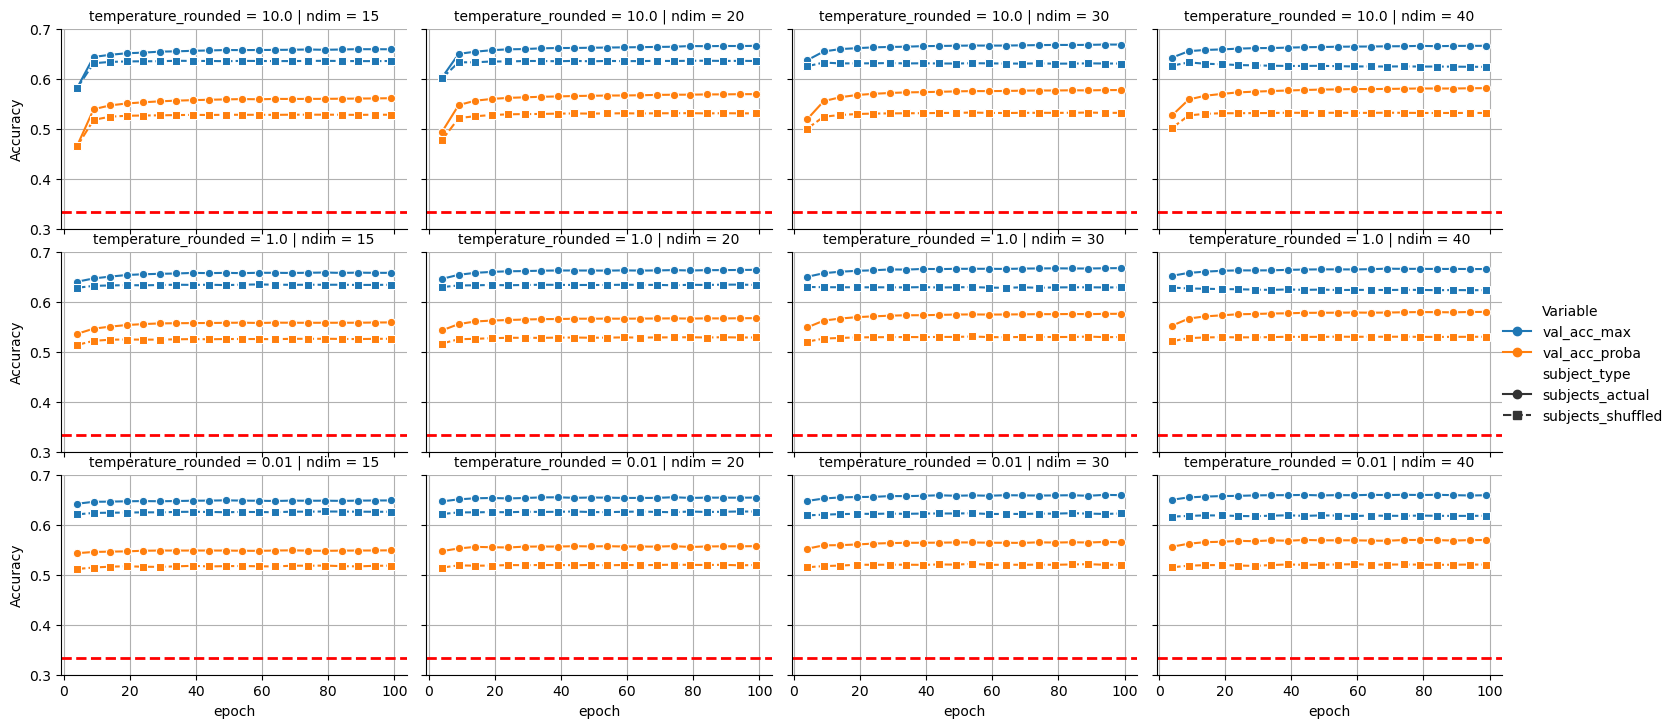

In [433]:
substring2 = "val_acc"
marker_styles = {
    "subjects_actual": "o",  # circle
    "subjects_shuffled": "s",  # square
}
# Create the FacetGrid without specifying an external axis
g = sns.relplot(
    data=df_train_eval_long_id_embedding.query(
        "(epoch + 1) % 5 == 0 & md == 'random_weights' & Variable.str.contains(@substring2)",
        engine="python"
    ), x='epoch', y='Accuracy', style = "subject_type", row="temperature_rounded", col="ndim", height=4,
    hue="Variable", marker="o", aspect=1, kind="line", markers=marker_styles
)
# Add gridlines to each facet z
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')

    ax.set_ylim(.3, .7)

plt.subplots_adjust(right=0.9)  # Increase from 0.8 to tuck it in

# Adjust the plot size
g.fig.set_size_inches(17,7)
g.fig.set_dpi(100)

plt.show()

In [507]:
df_embedding_best.head()

Variable,md,temperature,subject_type,ndim,val_acc_max,val_acc_proba
0,free_weights,0.01,subjects_actual,15,0.646685,0.547485
1,free_weights,0.01,subjects_actual,20,0.652455,0.554914
2,free_weights,0.01,subjects_actual,30,0.656531,0.562344
3,free_weights,0.01,subjects_actual,40,0.657039,0.566579
4,free_weights,0.01,subjects_shuffled,15,0.624247,0.516083


In [505]:
substring2 = "val_acc"
df_embedding_best = df_train_eval_long_id_embedding.query(
    "Variable.str.contains(@substring2)", engine="python"
).groupby(
    ["md", "temperature", "subject_type", "ndim", "Variable"]
)["Accuracy"].mean().reset_index()
df_embedding_best = df_embedding_best.pivot(
    index=["md", "temperature", "subject_type", "ndim"], 
    columns=["Variable"], values="Accuracy"
).reset_index()
df_embedding_best_modeltype = df_embedding_best.pivot(
    index=["temperature", "subject_type", "ndim"], 
    columns="md", values=["val_acc_max", "val_acc_proba"]
).reset_index()
# Assume df_pivot has MultiIndex columns after pivot
df_embedding_best_modeltype.columns = [
    '_'.join(col).rstrip('_') if isinstance(col, tuple) else str(col).rstrip('_') for col in df_embedding_best_modeltype.columns
]

df_embedding_best_modeltype.head()

,temperature,subject_type,ndim,val_acc_max_free_weights,val_acc_max_random_weights,val_acc_proba_free_weights,val_acc_proba_random_weights
0,0.01,subjects_actual,15,0.646685,0.646740,0.547485,0.547292
1,0.01,subjects_actual,20,0.652455,0.652637,0.554914,0.554893
2,0.01,subjects_actual,30,0.656531,0.656581,0.562344,0.562213
3,0.01,subjects_actual,40,0.657039,0.657325,0.566579,0.566646
4,0.01,subjects_shuffled,15,0.624247,0.624729,0.516083,0.516249


### look at by-participant dimensional weights

#### overview embedding values for ndim = 15
for different temperatures t

- t = 10 --> 0 - 4.2
- t = 1 --> 0 - 2.2
- t = .01 --> 0 - .85

#### overview dimensional weights (average)
- t = 10 --> 2
- t = 1 --> 1
- t = .01 --> .25

--> embedding values and dimensional weights scale with temperature.

i.e., the more deterministic, the smaller both, and vice versa

In [158]:
for i, l in enumerate(l_models_embedding_only):
    print("i = ", i)
    print("subject_type = ", l["subject_type"])
    print("modeltype = ", l["modeltype"])
    print("temperature = ", l["temperature"], "\n")

i =  0
subject_type =  subjects_actual
modeltype =  random_weights
temperature =  tensor(10.) 

i =  1
subject_type =  subjects_actual
modeltype =  random_weights
temperature =  tensor(1.) 

i =  2
subject_type =  subjects_actual
modeltype =  random_weights
temperature =  tensor(0.0100) 

i =  3
subject_type =  subjects_shuffled
modeltype =  random_weights
temperature =  tensor(10.) 

i =  4
subject_type =  subjects_shuffled
modeltype =  random_weights
temperature =  tensor(1.) 

i =  5
subject_type =  subjects_shuffled
modeltype =  random_weights
temperature =  tensor(0.0100) 

i =  6
subject_type =  subjects_actual
modeltype =  free_weights
temperature =  tensor(10.) 

i =  7
subject_type =  subjects_actual
modeltype =  free_weights
temperature =  tensor(1.) 

i =  8
subject_type =  subjects_actual
modeltype =  free_weights
temperature =  tensor(0.0100) 

i =  9
subject_type =  subjects_shuffled
modeltype =  free_weights
temperature =  tensor(10.) 

i =  10
subject_type =  subjects_s

In [391]:
df_dim_weights_random = pd.DataFrame(
    l_models_embedding_only[2]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
df_dim_weights_free = pd.DataFrame(
    l_models_embedding_only[8]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
df_dim_weights_random["id"] = df_dim_weights_random.index
df_dim_weights_random_long = df_dim_weights_random.melt(id_vars="id", var_name="Dimension")
df_dim_weights_random_long["modeltype"] = "random"
df_dim_weights_free["id"] = df_dim_weights_free.index
df_dim_weights_free_long = df_dim_weights_free.melt(id_vars="id", var_name="Dimension")
df_dim_weights_free_long["modeltype"] = "free"

df_dim_weights_long_both = pd.concat([df_dim_weights_free_long, df_dim_weights_random_long], axis=0)

In [392]:
# Define a function that returns two values
def summary(group):
    k2, pval = normaltest(group["value"])
    return pd.Series({
        'k2': k2,
        'pval': pval
    })

df_result = df_dim_weights_long_both.groupby(["Dimension", "modeltype"]).apply(summary).reset_index()
df_result_long = pd.melt(df_result, id_vars=["Dimension", "modeltype"])

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\1412867902.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result = df_dim_weights_long_both.groupby(["Dimension", "modeltype"]).apply(summary).reset_index()


In [393]:
df_result_long.head()

,Dimension,modeltype,variable,value
0,0,free,k2,6.669804
1,0,random,k2,15.234013
2,1,free,k2,35.988797
3,1,random,k2,50.214892
4,2,free,k2,8.266110


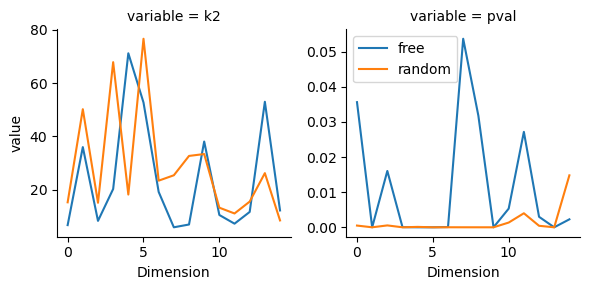

In [394]:
g = sns.FacetGrid(df_result_long, col="variable", sharey=False)
g.map_dataframe(sns.lineplot, x = "Dimension", y = "value", hue="modeltype")
plt.legend()

In [395]:
df_dim_weights_long_both["value_z"] = df_dim_weights_long_both.groupby(["Dimension", "modeltype"])["value"].transform(zscore)

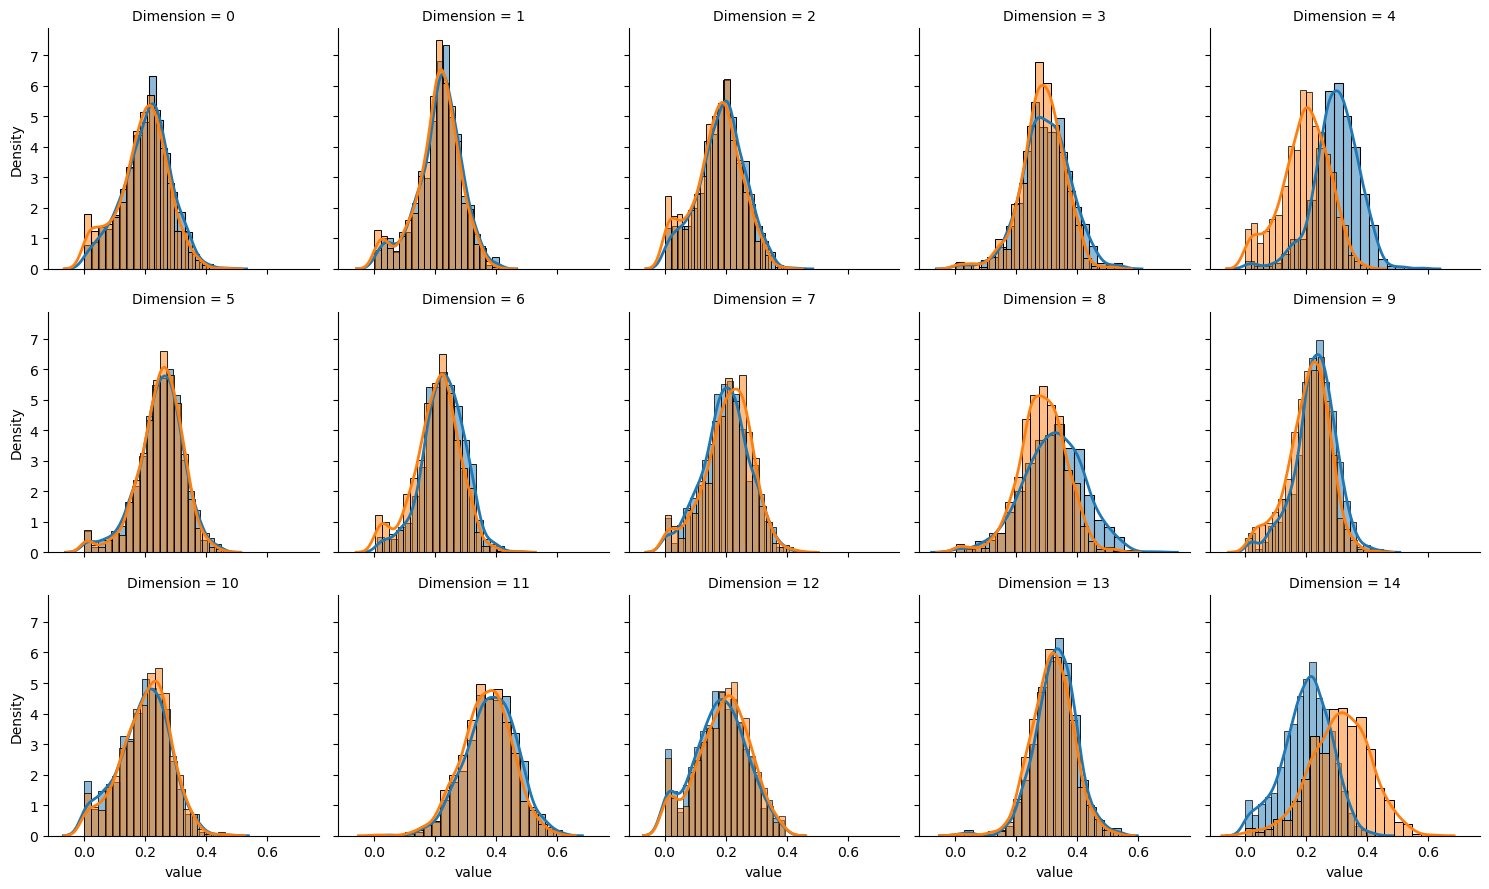

In [396]:
g = sns.FacetGrid(df_dim_weights_long_both, col="Dimension", hue="modeltype", col_wrap=5)
g.map(sns.histplot, 'value', bins=20, edgecolor='black', alpha=.5, stat="density")
g.map_dataframe(sns.kdeplot, x="value", fill=False, linewidth=2, common_norm=False, weights=.5)

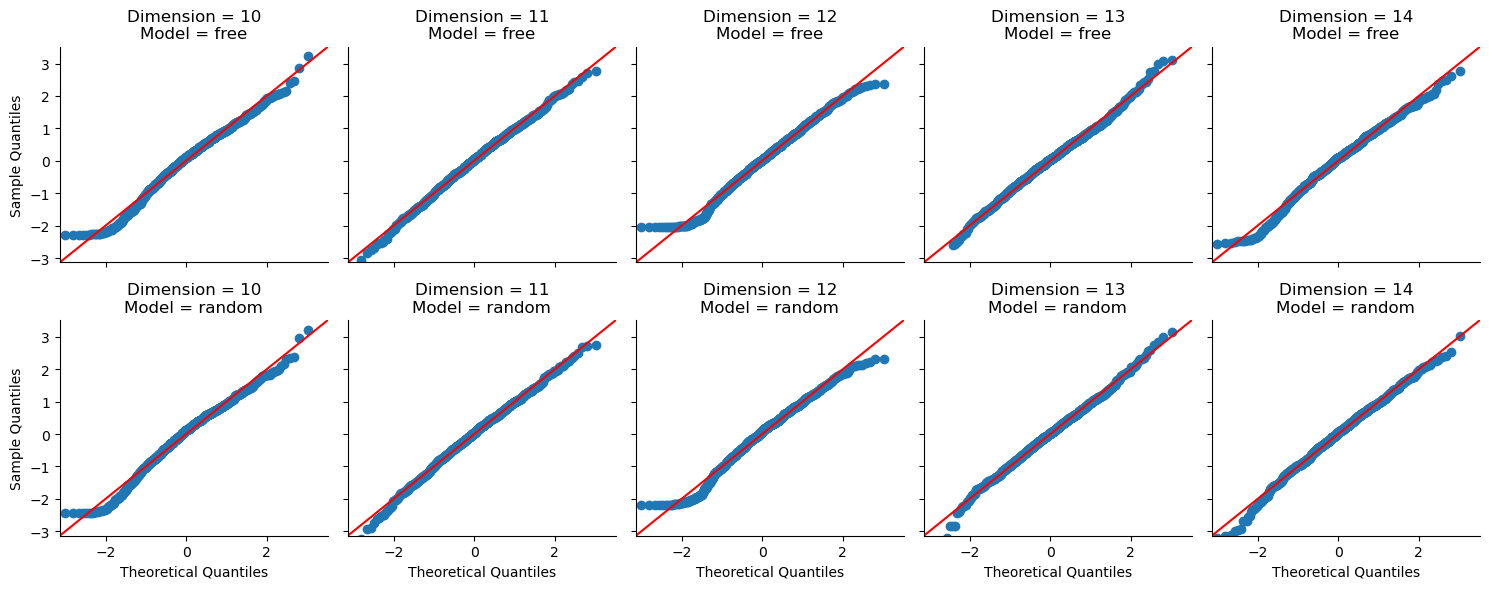

In [374]:
def qqplot_func(data, **kwargs):
    ax = plt.gca()
    sm.qqplot(data['value_z'], line='45', ax=ax)
    ax.set_title(
            f"Dimension = {data['Dimension'].iloc[0]}\nModel = {data['modeltype'].iloc[0]}"
    )
g = sns.FacetGrid(df_dim_weights_long_both.query("Dimension >= 10"), col="Dimension", row="modeltype")
g.map_dataframe(qqplot_func)

### look at item embeddings

In [375]:
df_item_embeddings_random = pd.DataFrame(
    l_models_embedding_only[2]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
df_item_embeddings_random.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.007175,0.215457,0.112561,0.000442,0.001502,0.087639,0.102757,0.036685,0.801545,0.039045,0.500240,0.054920,0.008731,0.009156,0.414473
1,0.571545,0.532938,0.196927,0.038474,0.250393,0.117771,0.133984,0.443775,0.032367,0.093325,0.156954,0.062338,0.632044,0.253528,0.036546
2,0.279310,0.253321,0.034536,0.057331,0.393988,0.165520,0.267747,0.420819,0.113943,0.097348,0.157881,0.031072,0.477211,0.395653,0.070473
3,0.214403,0.535816,0.530627,0.046190,0.130793,0.175005,0.009892,0.053797,0.133904,0.042811,0.355326,0.288281,0.326149,0.028178,0.517628
4,0.171777,0.037343,0.085156,0.096753,0.231751,0.127870,0.715424,0.217422,0.024186,0.083511,0.116657,0.073671,0.600685,0.389947,0.037290


In [376]:
df_item_embeddings_random = pd.DataFrame(
    l_models_embedding_only[2]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
df_item_embeddings_free = pd.DataFrame(
    l_models_embedding_only[8]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
df_item_embeddings_random["item_id"] = df_item_embeddings_random.index
df_item_embeddings_random["modeltype"] = "random"
df_item_embeddings_free["item_id"] = df_item_embeddings_free.index
df_item_embeddings_free["modeltype"] = "free"

df_item_embeddings_both = pd.concat([df_item_embeddings_random, df_item_embeddings_free], axis=0)

In [377]:
df_plot = df_item_embeddings_both.drop(columns=["item_id", "modeltype"]).transform(sorted, axis=1)
df_plot["modeltype"] = df_item_embeddings_both["modeltype"].copy()
df_plot["sum_embed"] = df_plot.drop(columns="modeltype").sum(axis=1)

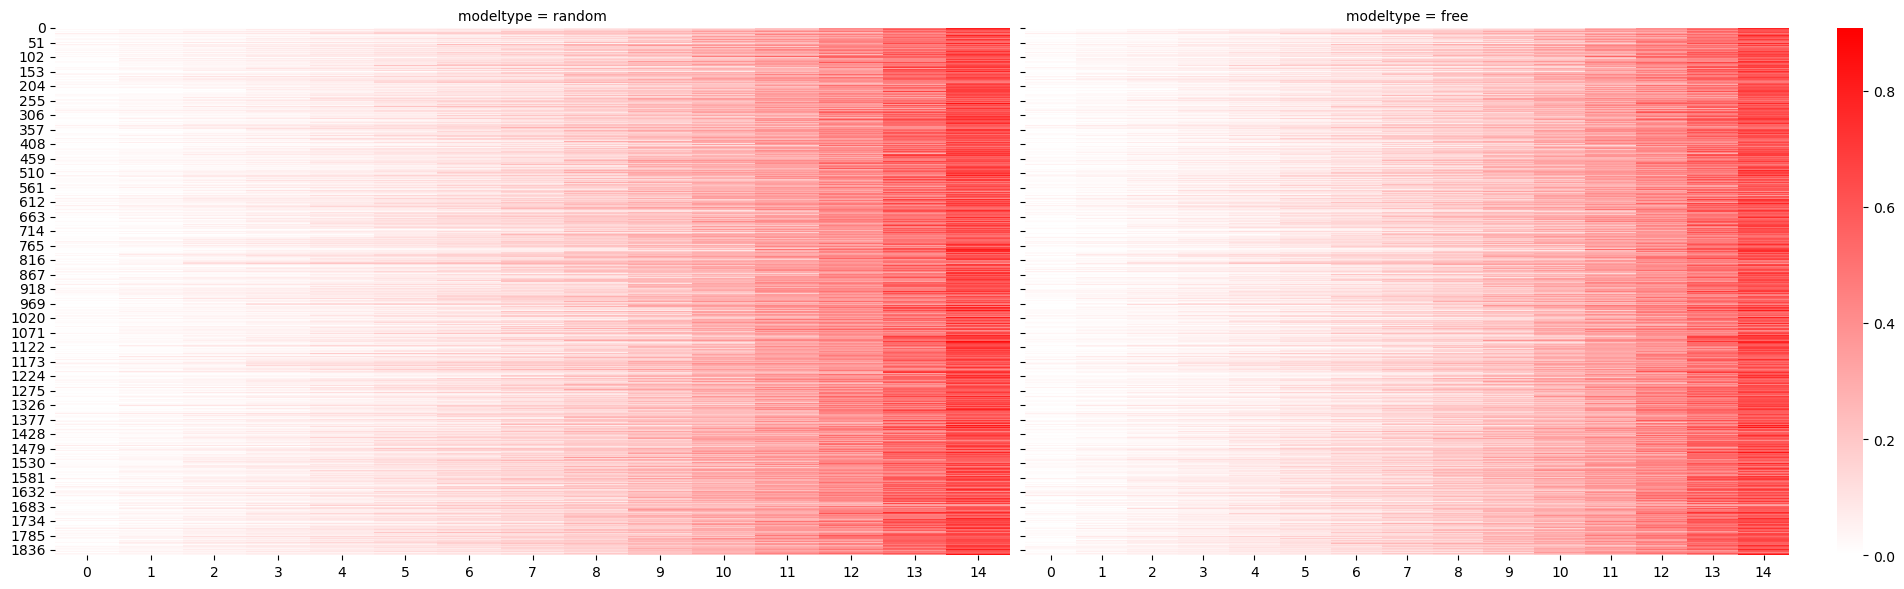

In [378]:
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap from white to red
white_red = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
vmin = 0
vmax = df_plot.drop(columns=["modeltype", "sum_embed"]).max(axis=1).max()
height = 6
aspect = 10 / 6 # width / height = aspect

g = sns.FacetGrid(df_plot.drop(columns="sum_embed"), col="modeltype", height=height, aspect=aspect)

# Plot the heatmap
def my_heatmap(data, **kwargs):
    data_use = data.drop(columns=["modeltype"], errors='ignore')
    if data.loc[0, "modeltype"] == "free":
        sns.heatmap(data_use, cmap=white_red, ax=plt.gca(), vmin=vmin, vmax=vmax, cbar=True)
    else:
        sns.heatmap(data_use, cmap=white_red, ax=plt.gca(), vmin=vmin, vmax=vmax, cbar=False)

g.map_dataframe(my_heatmap)
plt.show()

## embedding plus decision model

In [28]:
df_train_eval_long_id_decision.head()

,md,sparsity,subject_type,ndim,l,lh,epoch,Variable,Accuracy,lambda_ndim,modeltype_lh
0,random_weights_free_scaling,items_and_random_ids,subjects_actual,5,0.0005,0.01,0,train_acc_max,0.456612,0.0005_5,random_weights_free_scaling_0.01
1,random_weights_free_scaling,items_and_random_ids,subjects_actual,5,0.0005,0.01,1,train_acc_max,0.483733,0.0005_5,random_weights_free_scaling_0.01
2,random_weights_free_scaling,items_and_random_ids,subjects_actual,5,0.0005,0.01,2,train_acc_max,0.518065,0.0005_5,random_weights_free_scaling_0.01
3,random_weights_free_scaling,items_and_random_ids,subjects_actual,5,0.0005,0.01,3,train_acc_max,0.573295,0.0005_5,random_weights_free_scaling_0.01
4,random_weights_free_scaling,items_and_random_ids,subjects_actual,5,0.0005,0.01,4,train_acc_max,0.596064,0.0005_5,random_weights_free_scaling_0.01


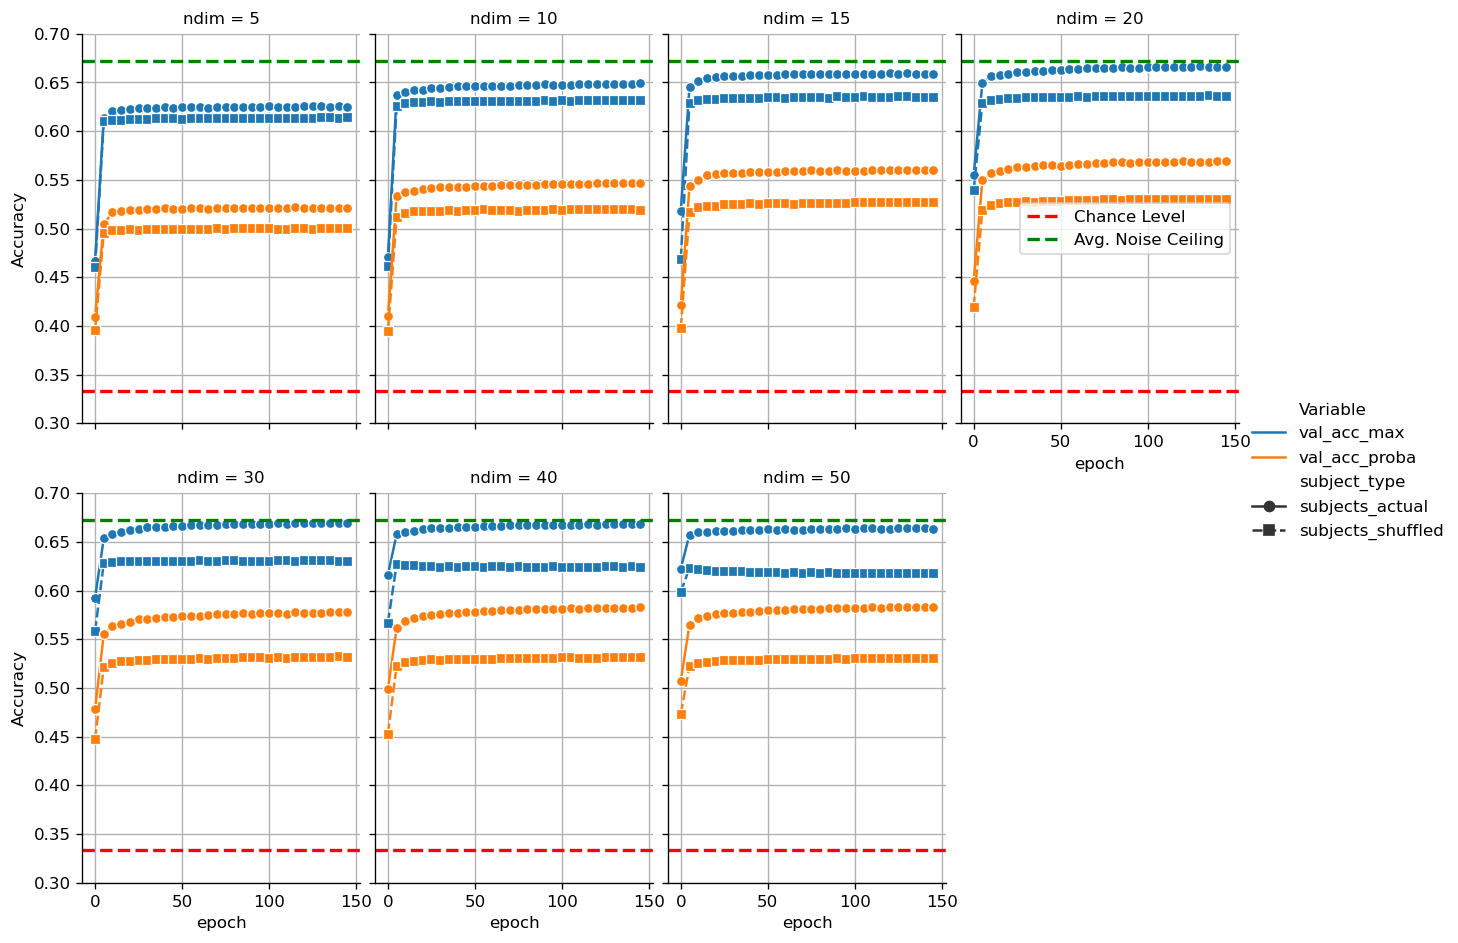

In [111]:
# Create the FacetGrid without specifying an external axis

g = sns.relplot(
    data=df_train_eval_long_id_decision.query(
        "epoch % 5 == 0 & Variable.str.contains(@substring2) & md == 'random_weights_free_scaling'",
        engine="python"
    ),
    x='epoch', y='Accuracy', col='ndim', height=4, col_wrap=4, 
    hue="Variable", style="subject_type", markers=marker_styles,
    kind="line", aspect=1
)


# Add gridlines to each facet z
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')
    ax.axhline(y=.6722, color='green', linestyle='--', linewidth=2, label='Avg. Noise Ceiling')
    ax.set_ylim(.3, .7)
    if i == 3:
        ax.legend()

plt.subplots_adjust(right=0.85)  # Increase from 0.8 to tuck it in

# Adjust the plot size
g.fig.set_size_inches(12, 8)
g.fig.set_dpi(120)

plt.show()

In [508]:
substring2 = "val_acc"
df_embedding_decision_best = df_train_eval_long_id_decision.query(
    "Variable.str.contains(@substring2)", engine="python"
).groupby(
    ["md", "subject_type", "ndim", "Variable"]
)["Accuracy"].mean().reset_index()

df_embedding_decision_best = df_embedding_decision_best.pivot(
    index=["md", "subject_type", "ndim"], 
    columns=["Variable"], values="Accuracy"
).reset_index()
df_embedding_decision_best_modeltype = df_embedding_decision_best.pivot(
    index=["subject_type", "ndim"], 
    columns="md", values=["val_acc_max", "val_acc_proba"]
).reset_index()
# Assume df_pivot has MultiIndex columns after pivot
df_embedding_decision_best_modeltype.columns = [
    '_'.join(col).rstrip('_') if isinstance(col, tuple) else str(col).rstrip('_') for col in df_embedding_decision_best_modeltype.columns
]


,subject_type,ndim,val_acc_max_random_weights_free_scaling,val_acc_proba_random_weights_free_scaling
0,subjects_actual,5,0.621674,0.517992
1,subjects_actual,10,0.644302,0.541933
2,subjects_actual,15,0.656230,0.556340
3,subjects_actual,20,0.662214,0.564215
4,subjects_actual,30,0.665655,0.572564


## Is random worse than free? Does adding by-participant temperatures help?

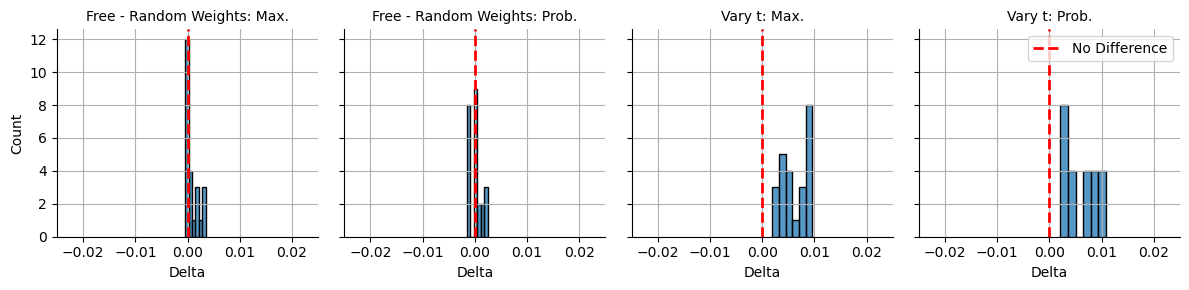

In [510]:
df_compare_models = pd.merge(
    df_embedding_best_modeltype, 
    df_embedding_decision_best_modeltype, 
    how = "left", on = ["subject_type", "ndim"]
)
df_compare_models["Free - Random Weights: Max."] = df_compare_models["val_acc_max_free_weights"] - df_compare_models["val_acc_max_random_weights"]
df_compare_models["Free - Random Weights: Prob."] = df_compare_models["val_acc_proba_free_weights"] - df_compare_models["val_acc_proba_random_weights"]
df_compare_models["Vary t: Max."] = df_compare_models["val_acc_max_random_weights_free_scaling"] - df_compare_models["val_acc_max_random_weights"]
df_compare_models["Vary t: Prob."] = df_compare_models["val_acc_proba_random_weights_free_scaling"] - df_compare_models["val_acc_proba_random_weights"]
df_hist = df_compare_models[["Free - Random Weights: Max.", "Free - Random Weights: Prob.", "Vary t: Max.", "Vary t: Prob."]].melt()
g = sns.FacetGrid(df_hist, col="variable", sharex=False)
g.map_dataframe(sns.histplot, x="value")

for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Difference')
    ax.set_xlabel("Delta")
    ax.set_xlim(-0.025, 0.025)

g.set_titles("{col_name}")  # If you just want the column name
_ = plt.legend()

*todos
- improvements per item difficulty
- test whether increasing lambda_hierarchical does make the distribution over participants more normal (in particular, lo outlier value)

## test split-half reliability of dimensional weights

In [52]:
def extract_split_half(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype = "weightsonly_only_weights", l_temperature = []
):
    all_dirs = []
    l_all_results = []
    l_all_models = []
    l_sparsity = []
    l_subject = []
    l_all_splithalf = []
    for n in l_n:
        for splithalf in l_splithalf:
            for la in lmbda:
                for la_h in lmbda_hierarchical:
                    for sp in l_sparse:
                        for st in l_subjecttype:
                            if l_temperature == []:
                                results_dir_ID = os.path.join(
                                    "./results", modelversion, f"modeltype_{modeltype}", f"splithalf_{splithalf}",
                                    f'{n}d', str(la), str(la_h), sp, st, f'seed{rnd_seed}'
                                    )
                            else:
                                for temp in l_temperature:
                                    results_dir_ID = os.path.join(
                                        "./results", modelversion, f"modeltype_{modeltype}", f"splithalf_{splithalf}", f"temperature_{temp}",
                                        f'{n}d', str(la), str(la_h), sp, st, f'seed{rnd_seed}'
                                        )
                            all_dirs.append(results_dir_ID)
                            l_sparsity.append(sp)
                            l_subject.append(st)
                            l_all_splithalf.append(splithalf)
    for i, d in enumerate(all_dirs):
        file_path = os.path.join(d, 'results.json')
        l_files = os.listdir(results_dir_ID)
        latest_epoch = max_epoch(l_files)
        p = os.path.join(d, "model", latest_epoch)
        if os.path.isfile(p):
            m = torch.load(p, weights_only=True, map_location=torch.device("cpu"))
            if modeltype == "random_weights_free_scaling":
                decision_weights = m["model_state_dict"]["model1.individual_slopes.weight"]
                temperature_scalings = m["model_state_dict"]["model2.individual_temps.weight"]
                dict_out = {"decision_weights": decision_weights, "temperature_scalings": temperature_scalings}
            else:
                decision_weights = m["model_state_dict"]["individual_slopes.weight"]
                dict_out = {"decision_weights": decision_weights}
            dict_out["modeltype"] = m["modeltype"]
            dict_out["lmbda"] = m["lambda"]
            dict_out["lmbda_hierarchical"] = m["lmbda_hierarchical"]
            dict_out["n_embed"] = m["n_embed"]
            dict_out["splithalf"] = l_all_splithalf[i]
            
            l_all_models.append(dict_out)
        else:
            print(f'{p} does not exist')
    return l_all_models

In [53]:
# by-participant embedding models (no by-participant decision models)
l_temperature = [0.009999999776482582, 100.0]
l_n = [5, 10]
lmbda_hierarchical = [0.0]
modelversion = "avg-ID-jointly-embeddings"
l_sparse = ["both"]
l_splithalf = ["1", "2"]
l_subjecttype = ["subjects_actual"]
l_splithalf_1 = extract_split_half(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="free_weights",
    l_temperature=l_temperature
)
lmbda_hierarchical = [0.01]
l_sparse = ["items_and_random_ids"]
l_splithalf_2 = extract_split_half(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="random_weights",
    l_temperature=l_temperature
)
modelversion = "avg-ID-jointly-embeddings-decision"
l_n = [3, 4, 5, 6, 7, 8, 9, 10]
l_splithalf_3 = extract_split_half(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="random_weights_free_scaling",
)


In [54]:
l_splithalf = l_splithalf_1 + l_splithalf_2 + l_splithalf_3

In [59]:
for i, l in enumerate(l_splithalf_3):
    print("i = ", i, ", ndim = ", l["n_embed"], ", splithalf = ", l["splithalf"])

i =  0 , ndim =  3 , splithalf =  1
i =  1 , ndim =  3 , splithalf =  2
i =  2 , ndim =  4 , splithalf =  1
i =  3 , ndim =  4 , splithalf =  2
i =  4 , ndim =  5 , splithalf =  1
i =  5 , ndim =  5 , splithalf =  2
i =  6 , ndim =  6 , splithalf =  1
i =  7 , ndim =  6 , splithalf =  2
i =  8 , ndim =  7 , splithalf =  1
i =  9 , ndim =  7 , splithalf =  2
i =  10 , ndim =  8 , splithalf =  1
i =  11 , ndim =  8 , splithalf =  2
i =  12 , ndim =  9 , splithalf =  1
i =  13 , ndim =  9 , splithalf =  2
i =  14 , ndim =  10 , splithalf =  1
i =  15 , ndim =  10 , splithalf =  2


In [60]:
def extract_decision_weights(l, tp):
    df_sh = pd.DataFrame(l["decision_weights"].detach().numpy()).reset_index(drop=False)
    df_sh = pd.melt(df_sh, id_vars=["index"], var_name='dimension', value_name='decision_weight')
    df_sh["timepoint"] = tp
    df_sh.rename(columns={"index":"id"}, inplace=True)
    return df_sh

manually select the relevant decision weight matrices and then compute the reliabilities per dimension

In [69]:
def split_half_reliabilities(l_splithalf, idxs, ndims):
    
    df_sh1 = extract_decision_weights(l_splithalf[idxs[0]], 1)
    df_sh2 = extract_decision_weights(l_splithalf[idxs[1]], 2)
    df_sh = pd.merge(df_sh1, df_sh2, how="left", on=["id", "dimension"], suffixes=["_1", "_2"])
    # Create a faceted scatterplot: one for each day
    def scatter_with_corr(data, x, y, **kwargs):
        r, _ = np.corrcoef(data[x], data[y])[0, 1], None
        z_val = data["dimension"].iloc[0]  # safely grab the facet value
        sns.scatterplot(data=data, x=x, y=y, **kwargs)
        plt.title(f"dimension = {z_val}, r = {r:.2f}")
        # Plot identity line
        min_val = min(data[x].min(), data[y].min())
        max_val = max(data[x].max(), data[y].max())
        _ = plt.plot([min_val, max_val], [min_val, max_val], color="gray", linestyle="--", linewidth=1)
        
    g = sns.FacetGrid(df_sh, col="dimension", col_wrap=5)
    g.map_dataframe(scatter_with_corr, x="decision_weight_1", y="decision_weight_2")

    df_corr = pd.DataFrame(
        df_sh.groupby("dimension").apply(lambda g: g['decision_weight_1'].corr(g['decision_weight_2'])).sort_values(ascending=False)
    )
    df_corr["ndims"] = ndims
    df_corr.columns = ["r", "ndims"]

    return df_sh, df_corr, g

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\3227978693.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sh.groupby("dimension").apply(lambda g: g['decision_weight_1'].corr(g['decision_weight_2'])).sort_values(ascending=False)
C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\3227978693.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sh.groupby("dimension").apply(lambda g

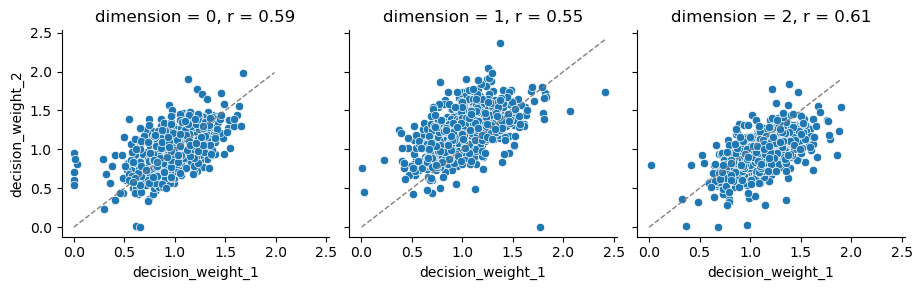

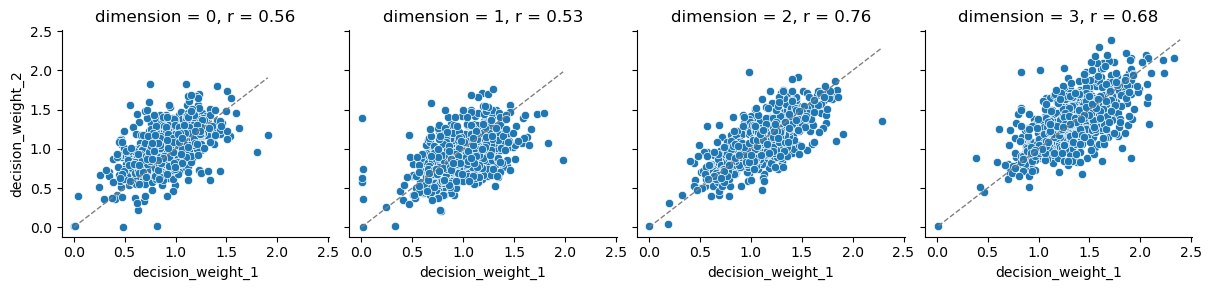

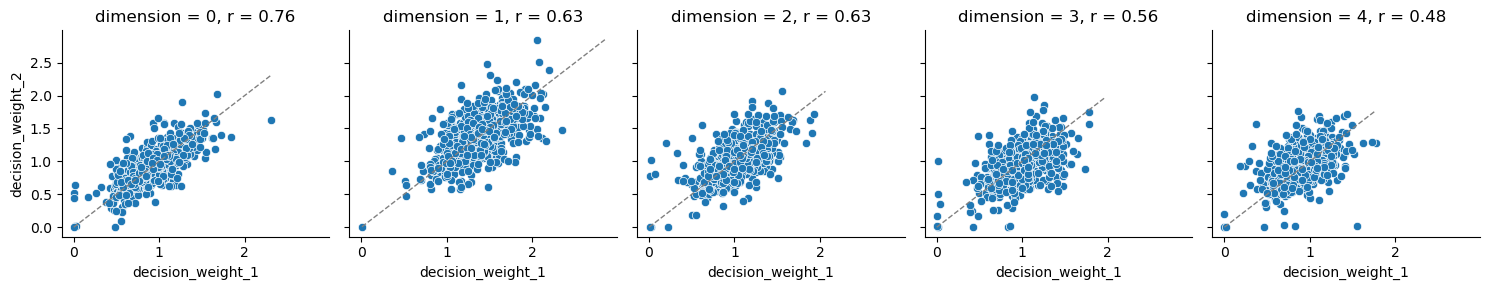

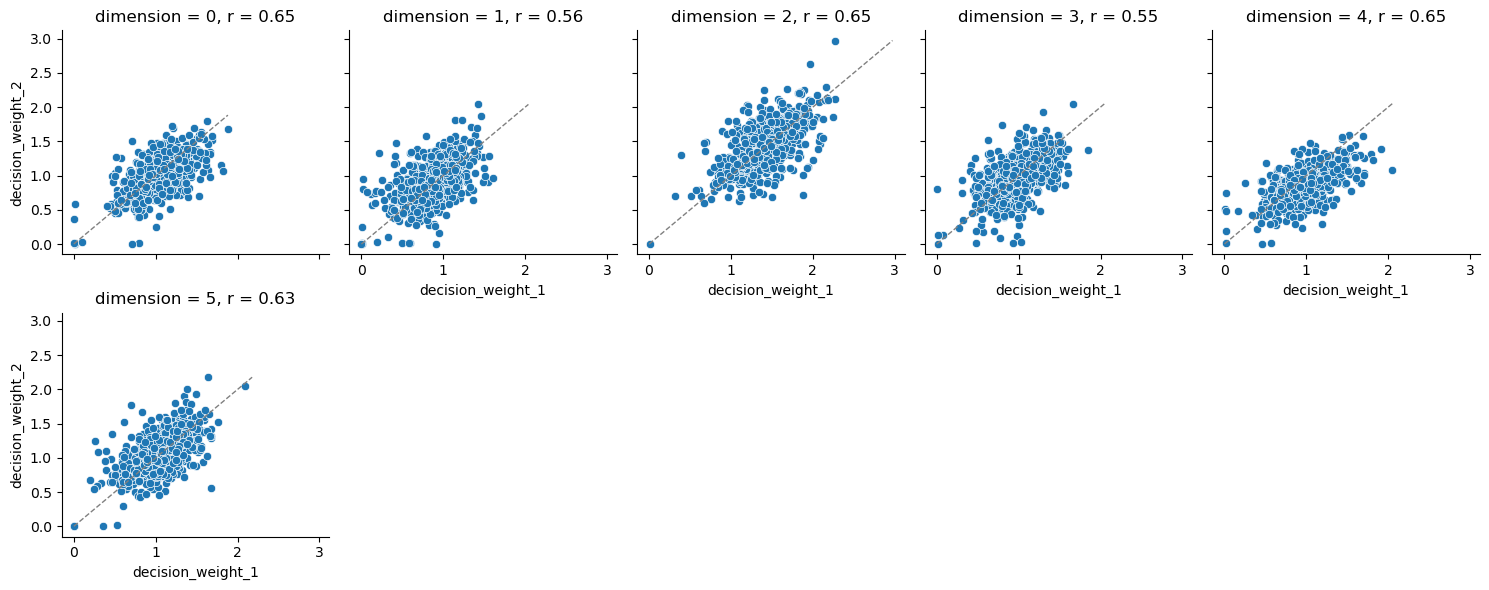

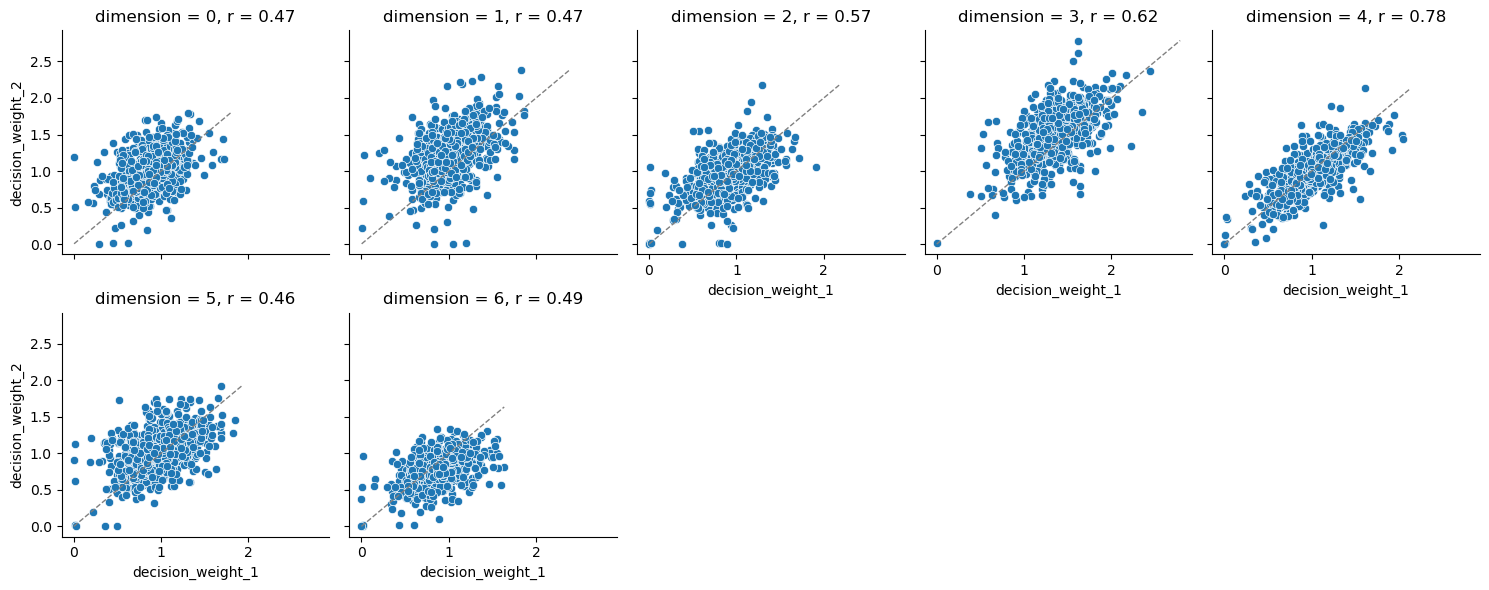

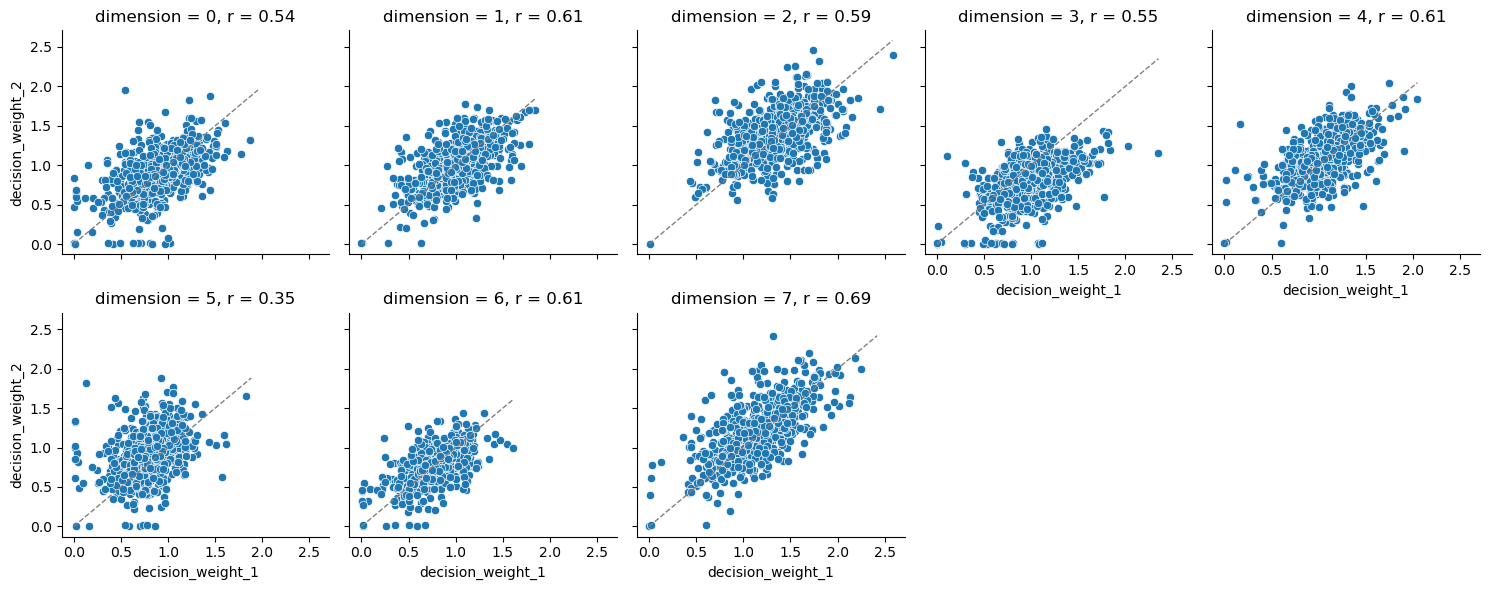

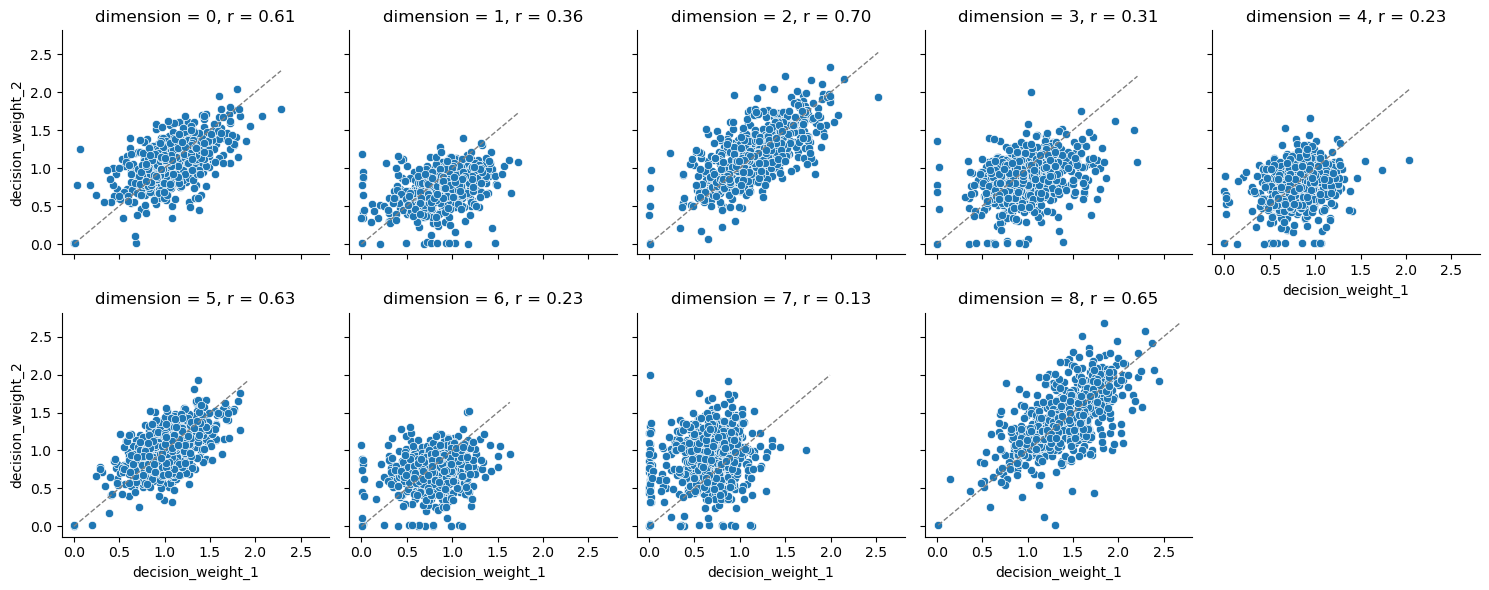

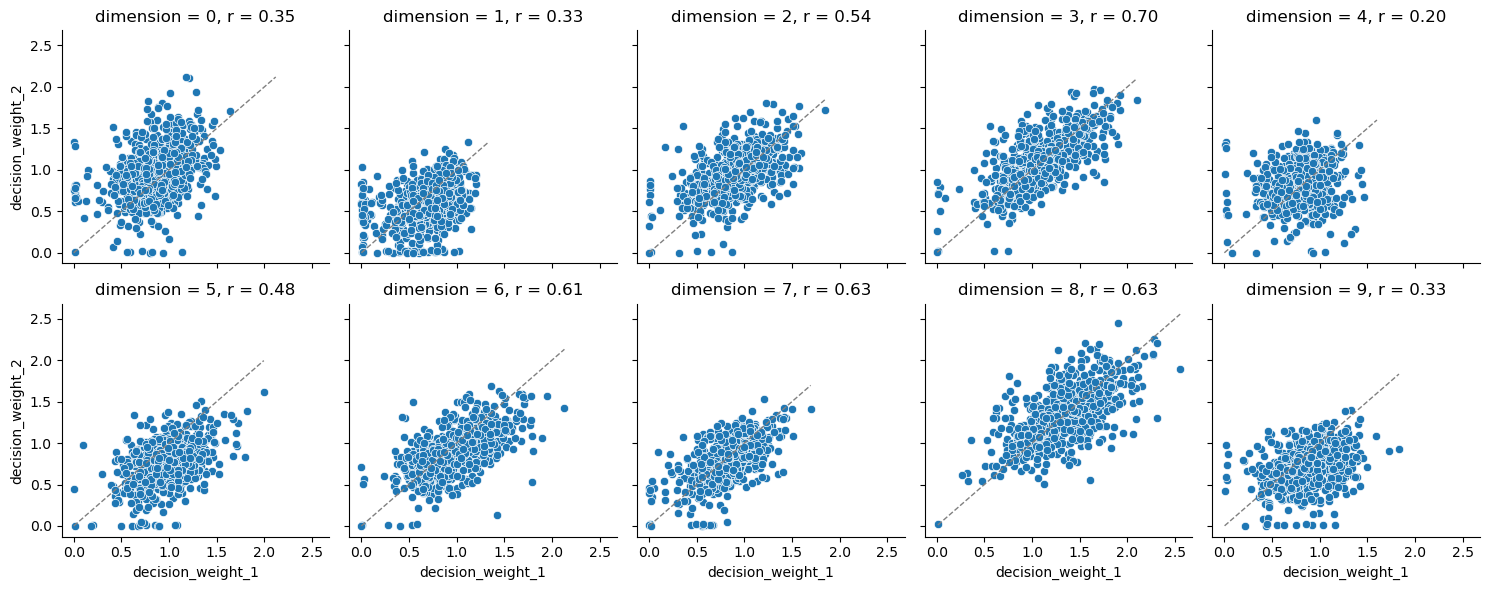

In [71]:
df_sh_3, df_corr_3, g_3 = split_half_reliabilities(l_splithalf_3, [0, 1], 3)
df_sh_4, df_corr_4, g_4 = split_half_reliabilities(l_splithalf_3, [2, 3], 4)
df_sh_5, df_corr_5, g_5 = split_half_reliabilities(l_splithalf_3, [4, 5], 5)
df_sh_6, df_corr_6, g_6 = split_half_reliabilities(l_splithalf_3, [6, 7], 6)
df_sh_7, df_corr_7, g_7 = split_half_reliabilities(l_splithalf_3, [8, 9], 7)
df_sh_8, df_corr_8, g_8 = split_half_reliabilities(l_splithalf_3, [10, 11], 8)
df_sh_9, df_corr_9, g_9 = split_half_reliabilities(l_splithalf_3, [12, 13], 9)
df_sh_10, df_corr_10, g_10 = split_half_reliabilities(l_splithalf_3, [14, 15], 10)

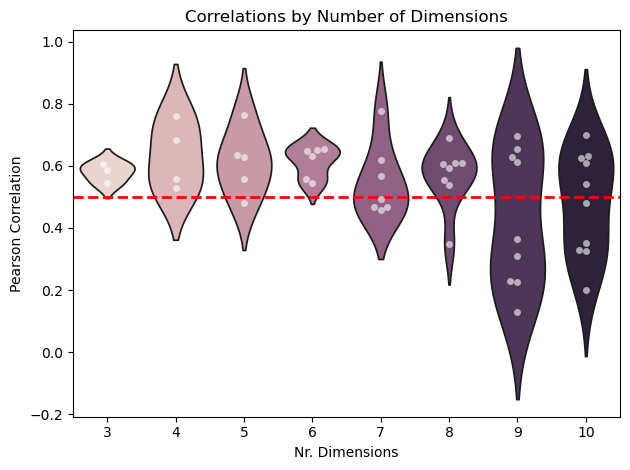

In [74]:
df_corrs = pd.concat([df_corr_3, df_corr_4, df_corr_5, df_corr_6, df_corr_7, df_corr_8, df_corr_9, df_corr_10], axis=0)
# Violin plot
sns.violinplot(data=df_corrs, x="ndims", y="r", hue="ndims", inner=None)

# Swarm plot on top
sns.swarmplot(data=df_corrs, x="ndims", y="r",  color="white", alpha=0.6)

plt.axhline(y=.5, color='red', linestyle='--', linewidth=2, label='Chance Level')
plt.xlabel("Nr. Dimensions")
plt.ylabel("Pearson Correlation")


# Remove duplicate legend
plt.legend([], [], frameon=False)

plt.title("Correlations by Number of Dimensions")
plt.tight_layout()

In [82]:
# Create the FacetGrid without specifying an external axis
substring = "random_weights_free_scaling"
substring2 = "val_acc"
g = sns.relplot(
    data=df_train_eval_long_id.query(
        "epoch % 5 == 0 & Variable.str.contains(@substring2) & md.str.contains(@substring)",
        engine="python"
    ), x='epoch', y='Accuracy', col='subject_type', row="md",height=4,
    hue="Variable", marker="o", aspect=1, kind="line"
)
# Add gridlines to each facet z
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')

    ax.set_ylim(.3, .7)
    if i == 0:
        ax.legend()
        
# Adjust the plot size
g.fig.set_size_inches(9, 5)
g.fig.set_dpi(150)

plt.show()

KeyError: 'md'

Evaluate winning model against best avg model

In [62]:
df_id_best = df_train_eval_long_id.query(
    "`lambda` == 0.0005 & ndim == 15 & subject_type == 'subjects_actual'"
).copy()
df_id_best["id_level"] = "ID"

UndefinedVariableError: name 'BACKTICK_QUOTED_STRING_lambda' is not defined

In [ ]:
# Create the FacetGrid without specifying an external axis
g = sns.relplot(
    data=df_train_eval_long_avg.query("epoch <= 749 & epoch % 25 == 0"), x='epoch', y='Accuracy', 
    col='ndim', row="lambda", height=4, hue="Variable",
    marker="o", aspect=1, kind="line")
# Add gridlines to each facet 
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')
    
    #ax.set_xlim(0, 400)
    ax.set_ylim(0, 1)
    if i == 0:
        ax.legend()

# Adjust the plot size
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(150)

plt.show()

In [ ]:
df_avg_best = df_train_eval_long_avg.query("`lambda` == 0.0005 & ndim == 15").copy()
df_avg_best["id_level"] = "avg"

In [ ]:
cols_shared = np.intersect1d(df_id_best.columns, df_avg_best.columns)
df_best_both = pd.concat([df_id_best[cols_shared], df_avg_best[cols_shared]])

In [ ]:
df_best_both.head()

In [ ]:
# Create the FacetGrid without specifying an external axis
palette = sns.color_palette("Set2")[2:]
g = sns.relplot(
    data=df_best_both.query("Variable == 'val_acc' & epoch <= 100"), x='epoch', y='Accuracy', 
    height=4, hue="id_level", palette=palette,
    marker="o", aspect=1, kind="line")
# Add gridlines to each facet 
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    #ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')
    
    #ax.set_xlim(0, 400)
    ax.set_ylim(.59, .64)
    if i == 0:
        ax.legend()

# Adjust the plot size
g.fig.set_size_inches(8, 5)
g.fig.set_dpi(150)

plt.show()

In [ ]:
l_all_models_id[3]["model_state_dict"]["fc.weight"].shape

In [ ]:
l_all_models_id[3]["model_state_dict"]["individual_slopes.weight"].shape

# Comparison per Participant

In [121]:
for i, l in enumerate(l_all_models_id_1):
    print("i = ", i)
    print("n_embed = ", l["n_embed"])
    print("subject_type = ", l["subject_type"], "\n")

i =  0
n_embed =  5
subject_type =  subjects_actual 

i =  1
n_embed =  5
subject_type =  subjects_shuffled 

i =  2
n_embed =  10
subject_type =  subjects_actual 

i =  3
n_embed =  10
subject_type =  subjects_shuffled 

i =  4
n_embed =  15
subject_type =  subjects_actual 

i =  5
n_embed =  15
subject_type =  subjects_shuffled 

i =  6
n_embed =  20
subject_type =  subjects_actual 

i =  7
n_embed =  20
subject_type =  subjects_shuffled 

i =  8
n_embed =  30
subject_type =  subjects_actual 

i =  9
n_embed =  30
subject_type =  subjects_shuffled 

i =  10
n_embed =  40
subject_type =  subjects_actual 

i =  11
n_embed =  40
subject_type =  subjects_shuffled 

i =  12
n_embed =  50
subject_type =  subjects_actual 

i =  13
n_embed =  50
subject_type =  subjects_shuffled 



In [113]:
len(l_all_models_id_1)

14

In [122]:
triplets_dir = './data/'
device = "cpu"
# load triplets into memory
train_triplets, test_triplets = ut.load_data_ID(
    device=device, triplets_dir=triplets_dir, testcase=False)


...Could not find any .npy files for current modality.
...Now searching for .txt files.



In [124]:
l_all_models_id_1[8]["subject_type"]

'subjects_actual'

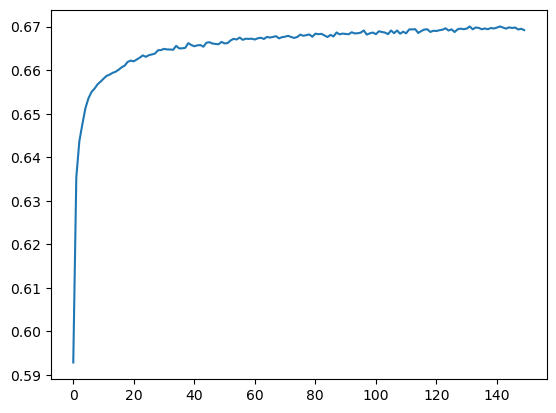

In [125]:
plt.plot(l_all_models_id_1[8]["val_accs_max"])

In [128]:
array_weights_items = np.array(l_all_models_id_1[8]["model_state_dict"]["model1.fc.weight"]).transpose()
array_weights_id = l_all_models_id_1[8]["model_state_dict"]["model1.individual_slopes.weight"]

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\1834385748.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  array_weights_items = np.array(l_all_models_id_1[8]["model_state_dict"]["model1.fc.weight"]).transpose()


In [129]:
anchors = torch.Tensor(np.array([array_weights_items[i,:] for i in list(test_triplets[:, 0])]))
positives = torch.Tensor(np.array([array_weights_items[i,:] for i in list(test_triplets[:, 1])]))
negatives = torch.Tensor(np.array([array_weights_items[i,:] for i in list(test_triplets[:, 2])]))

In [576]:
anchors = np.array([array_weights_items[i,:] for i in list(test_triplets[:, 0])])
positives = np.array([array_weights_items[i,:] for i in list(test_triplets[:, 1])])
negatives = np.array([array_weights_items[i,:] for i in list(test_triplets[:, 2])])

In [131]:
ids = test_triplets[:, 3].numpy()

In [132]:
anchors_weighted = [a*array_weights_id.numpy()[ids[id], :] for id, a in enumerate(anchors)]
positives_weighted = [a*array_weights_id.numpy()[ids[id], :] for id, a in enumerate(positives)]
negatives_weighted = [a*array_weights_id.numpy()[ids[id], :] for id, a in enumerate(negatives)]

In [133]:
from functools import partial

In [134]:
f_partial = partial(ut.delta_avg_id, anchors, positives, negatives, anchors_weighted, positives_weighted, negatives_weighted, ids)

In [135]:
ids_unique_sorted = np.sort(np.unique(ids))

In [136]:
l_deltas = list(map(f_partial, ids_unique_sorted))

In [146]:
deltas_participant = []
for l in l_deltas:
    deltas_participant.append(l[0])

In [147]:
df_ns = pd.DataFrame(ids, columns=['id'])
df_ns = df_ns.groupby("id")["id"].count() * 4
df_ns = df_ns.reset_index(name = "n_train")
df_ns["delta"] = deltas_participant

In [148]:
df_ns.to_csv("data/deltas-learned-weighted-embeddings.csv")

In [140]:
df_ns.head()

,id,n_train,delta
0,0,2048,"(0.0625, [False, True, True, False, False, Tru..."
1,1,256,"(0.0, [False, False, True, False, False, True,..."
2,2,560,"(0.0357142857142857, [True, True, True, True, ..."
3,3,832,"(0.033653846153846145, [False, False, False, T..."
4,4,240,"(0.0, [True, False, False, True, False, False,..."


# Extract Item Embeddings, random by-particpiant decision weights, and free by-participant decision scaling factors

In [ ]:
# Define file path (ensure it matches how it was saved)
file_path = os.path.join("./results/avg-ID-jointly/modeltype_random_weights_free_scaling/15d/0.0005/both/subjects_actual/seed852", f'sparse_embed_epoch{75:04d}.txt')

# Load the saved tensor back into NumPy
W_loaded = np.loadtxt(file_path)

In [514]:
df_diagnostic = pd.read_csv("data/diagnostic-triplets.csv")

In [518]:
df_diagnostic.head()

,id_lo,id_mid,id_hi,n
0,0,146,1534,102
1,0,176,1227,114
2,0,192,1088,17
3,0,688,1307,110
4,1,502,1157,106


In [542]:
df_test_triplets = pd.DataFrame(test_triplets)
df_train_triplets = pd.DataFrame(train_triplets)
df_train_test = pd.concat([df_train_triplets, df_test_triplets], axis=0)

In [549]:
cols = [0, 1, 2]
vals = df_train_test[cols].to_numpy()

# Compute lo, hi, and mid values using vectorized operations
id_lo = np.min(vals, axis=1)
id_hi = np.max(vals, axis=1)

# Calculate id_mid: total - min - max
id_sum = vals.sum(axis=1)
id_mid = id_sum - id_lo - id_hi

# Assign to the DataFrame
df_train_test['id_lo'] = id_lo
df_train_test['id_mid'] = id_mid
df_train_test['id_hi'] = id_hi

df_train_test.rename(columns={3:"id_subject"}, inplace=True)
# filter diagnostic triplets from choices
df_diagnostic_data = pd.merge(df_diagnostic, df_train_test, how="inner", on=["id_lo", "id_mid", "id_hi"])

In [604]:
df_diagnostic_data.head()

,id_lo,id_mid,id_hi,n,0,1,2,id_subject
0,0,146,1534,102,146,0,1534,7
1,0,146,1534,102,0,146,1534,7
2,0,146,1534,102,0,146,1534,12
3,0,146,1534,102,0,146,1534,32
4,0,146,1534,102,146,0,1534,41


In [606]:
# Create a string-based triplet_id column from id_lo, id_mid, id_hi
df_diagnostic_data["triplet_id"] = (
    df_diagnostic_data[["id_lo", "id_mid", "id_hi"]]
    .astype(str)
    .agg("".join, axis=1)  # concatenate values without separators
)
df_diagnostic_data["triplet_id"] = pd.Categorical(df_diagnostic_data["triplet_id"])
# Convert to categorical and assign integer labels starting from 1
df_diagnostic_data["triplet_id"] = (
    pd.Categorical(df_diagnostic_data["triplet_id"])
    .rename_categories(lambda x: str(df_diagnostic_data["triplet_id"].cat.categories.get_loc(x) + 1))
)

In [607]:
df_diagnostic_data.head()

,id_lo,id_mid,id_hi,n,0,1,2,id_subject,triplet_id
0,0,146,1534,102,146,0,1534,7,1
1,0,146,1534,102,0,146,1534,7,1
2,0,146,1534,102,0,146,1534,12,1
3,0,146,1534,102,0,146,1534,32,1
4,0,146,1534,102,146,0,1534,41,1


In [583]:
anchors = torch.Tensor(np.array([array_weights_items[i,:] for i in list(df_diagnostic_data.loc[:, 0])]))
positives = torch.Tensor(np.array([array_weights_items[i,:] for i in list(df_diagnostic_data.loc[:, 1])]))
negatives = torch.Tensor(np.array([array_weights_items[i,:] for i in list(df_diagnostic_data.loc[:, 2])]))

In [589]:
anchors_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(anchors)]
positives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(positives)]
negatives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(negatives)]

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\1006436363.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anchors_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(anchors)]
C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\1006436363.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  positives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(positives)]
C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\1006436363.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  negatives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate

In [613]:
anchors.shape

torch.Size([103757, 30])

In [618]:
anchors_weighted = torch.vstack(anchors_weighted)
positives_weighted = torch.vstack(positives_weighted)
negatives_weighted = torch.vstack(negatives_weighted)

In [619]:
sims_avg = ut.compute_similarities(
    anchors, positives, negatives, method="odd_one_out")
sims_id = ut.compute_similarities(
        anchors_weighted, positives_weighted, negatives_weighted, method="odd_one_out")
one_avg = (sims_avg[0] > sims_avg[1]).numpy() & (
        sims_avg[0] > sims_avg[2]).numpy()
one_id = (sims_id[0] > sims_id[1]).numpy() & (
        sims_id[0] > sims_id[2]).numpy()

In [621]:
df_diagnostic_data["correct_avg"] = one_avg
df_diagnostic_data["correct_id"] = one_id

In [672]:
df_items_delta = (
    df_diagnostic_data
    .groupby("triplet_id")
    .agg(
        correct_avg=("correct_avg", "mean"),
        correct_id=("correct_id", "mean"),
        n=("correct_avg", "count")  # or use any column to count rows
    )
    .reset_index()
)
df_items_delta["delta"] = df_items_delta["correct_id"] - df_items_delta["correct_avg"]
df_items_delta["Accuracy Avg. Model"] = pd.cut(df_items_delta["correct_avg"], 10, labels=False)


C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\3569573228.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("triplet_id")


In [673]:
# Group by 'correct_avg_bin' and compute the weighted average of 'delta'
df_summary = (
    df_items_delta.groupby(["Accuracy Avg. Model"])
    .apply(lambda g: pd.Series({
        "Delta (weighted)": (g["delta"] * g["n"]).sum() / g["n"].sum(),
        "Total Nr. Responses": g["n"].sum()
    }))
    .reset_index()
)

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\2089537035.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [674]:
df_summary

,Accuracy Avg. Model,Delta (weighted),Total Nr. Responses
0,0,0.715262,439.0
1,1,0.535278,1474.0
2,2,0.373417,6079.0
3,3,0.234686,10938.0
4,4,0.123684,12257.0
5,5,0.065412,12857.0
6,6,0.034385,14454.0
7,7,0.012895,17991.0
8,8,0.001116,13437.0
9,9,-0.001446,13831.0


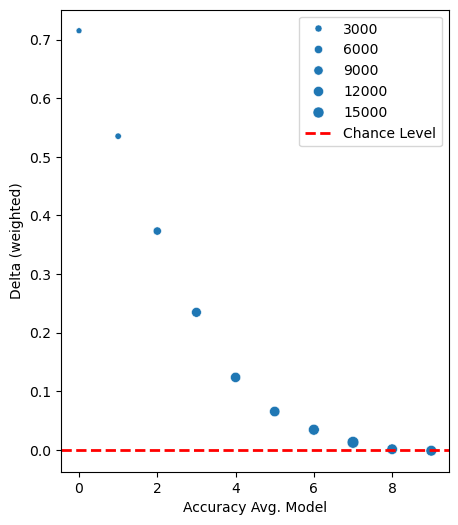

In [680]:
f, ax = plt.subplots(1, 1, figsize = (5, 6))
sns.scatterplot(data=df_summary, x="Accuracy Avg. Model", y="Delta (weighted)", size="Total Nr. Responses")
ax.axhline(y=0, color="red",linestyle='--', linewidth=2, label='Chance Level')
_ = ax.legend()